# inspect_study.py

This notebook enables some simple visualization of the data contained in a given datasheet within the vgp database.

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

First we specify the datasheet to be visualized (either by the name of the datasheet or by its numeric ID). We then read in the data and assign the study-level poles and site-level vgps to two different dataframes.

In [2]:
datasheet_name = 'Western_Central_TMVB' #None or specify name e.g. 'Western_Central_TMVB'
datasheet_id = None #None or specify numeric ID

if datasheet_name is not None:
    fname = os.getcwd() + '/vgp_database/%s.xlsx' % datasheet_name
#else:
    #assign fname based on numeric ID

#read in data and assign to dataframes
poles = pd.read_excel(fname, engine='openpyxl', sheet_name='poles')
vgps = pd.read_excel(fname, engine='openpyxl', sheet_name='vgps')

Now we extract from the vgp dataframe the list of unique study-level poles represented in the dataset (ignoring '0', which denotes poles that are not used in any pole computation).

In [3]:
#get list of unique poles from vgps
vgp_pole_list = vgps['in_study_pole'].astype(str).str.split(',\s*').explode()
uniq_poles = set(vgp_pole_list)
if '0' in uniq_poles: uniq_poles.discard('0')

For each pole, we now find the constituent site-level data and: 
1) ensure that it is complete (otherwise attempt to fill in the missing entries) and correct
2) determine the polarity of the individual vgps
3) cast all vgps into a common polarity and re-compute the Fisher mean
4) plot the site locations, vgps, and the results of reversal and Fisher distribution tests

Analyzing pole 2
inverting vgp from site pwrLIB
inverting vgp from site pwnPAL
inverting vgp from site pwrJAL
inverting vgp from site pwrSJG
inverting vgp from site pwrFER
inconsistent combination of site coordinates + dec/inc + vgp data from site pcrTRA
inverting vgp from site pcrCHA
inverting vgp from site mcrFIN
inverting vgp from site pcrTRO
inverting vgp from site pcrOCO
inverting vgp from site pcrPEN
inverting vgp from site pcrHUA
inverting vgp from site pcrSOL
inverting vgp from site mcrCAN
inverting vgp from site mcrORD
inverting vgp from site mcrAZU
Reported paleopole 2: N=33, plat=88.0, plon=265.5, A95=5.0
Recomputed paleopole 2: N=33, plat=88.0, plon=265.4, A95=5.0


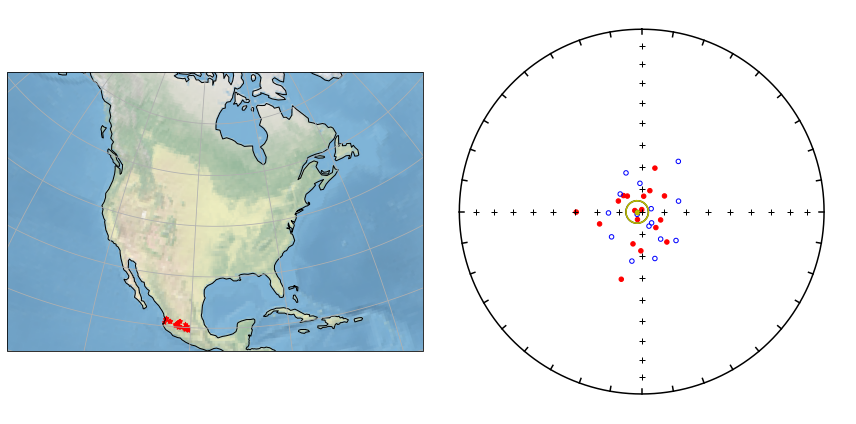

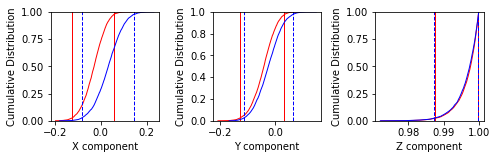

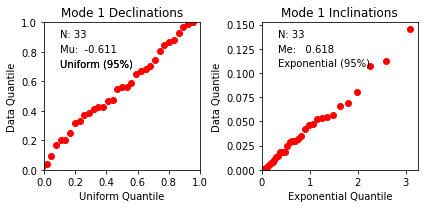

Analyzing pole 1
inverting vgp from site qcrCG
inverting vgp from site qcrEST
inverting vgp from site qcrROD
inverting vgp from site qcrCSA
Reported paleopole 1: N=10, plat=86.7, plon=314.0, A95=7.5
Recomputed paleopole 1: N=10, plat=86.7, plon=314.0, A95=7.5


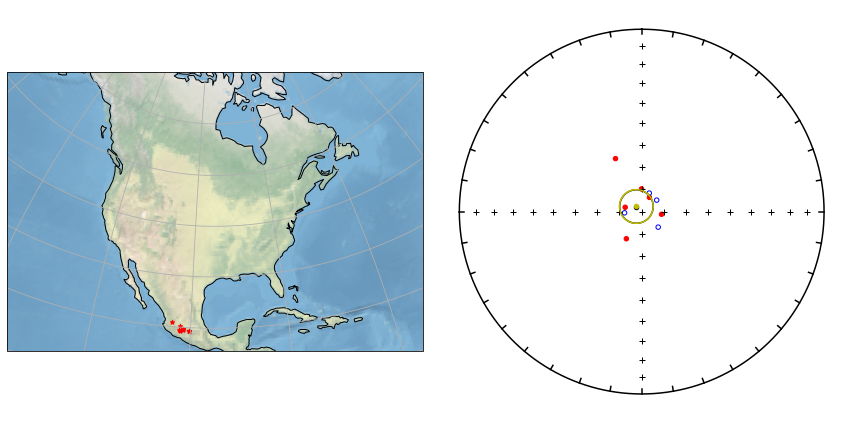

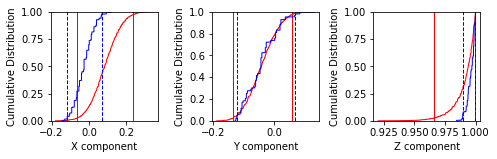

Not enough sites to conduct quantile-quantile test


In [4]:
for pole in uniq_poles:
    
    print ('Analyzing pole %s' % pole)
    selected_pole = poles[poles['pole'].astype(str) == pole] #get the corresponding reported pole
    selected_vgps = vgps.iloc[vgp_pole_list.index[vgp_pole_list == pole].tolist()] #get the corresponding vgps
    
    #find any entries where site coordinates are missing and calculate them (if dec/inc and vgp provided)
    get_sloc = vgps.iloc[selected_vgps.index[selected_vgps['slat'].isna() | selected_vgps['slon'].isna()].tolist()]
    
    if (((get_sloc['dec'].isna() | get_sloc['inc'].isna()) & (get_sloc['VGP_lat'].isna() | get_sloc['VGP_lon'].isna())).any()):
        print ('Missing dec/inc and/or vgp in row(s) where no site coordinates are reported; cannot calculate site locations')
        
    #else:*** TO DO: compute site coordinates and assign back to selected_vgps dataframe ***
    
    #find any entries where vgp is missing and calculate it (if slat/slon and dec/inc are provided)
    get_vgp = vgps.iloc[selected_vgps.index[selected_vgps['VGP_lat'].isna() | selected_vgps['VGP_lat'].isna()].tolist()]
    
    if (((get_vgp['slat'].isna() | get_vgp['slon'].isna()) & (get_vgp['dec'].isna() | get_vgp['inc'].isna())).any()):
        print ('Missing slat/slon and/or dec/inc in row(s) where no vgp is reported; cannot calculate vgp')
    
    else: ipmag.vgp_calc(get_vgp, site_lon='slon', site_lat='slat', dec_tc='dec', inc_tc='inc')
    
    #assign recalculated vgps back to selected_vgps dataframe
    selected_vgps.VGP_lat.fillna(get_vgp.vgp_lat, inplace=True)
    selected_vgps.VGP_lon.fillna(get_vgp.vgp_lon, inplace=True)
    
    #check polarity of VGPs against directions...**here abandonded vectorization because angle.py only accepts single comparisons; should find alternative...**
    ipmag.vgp_calc(selected_vgps, site_lon='slon', site_lat='slat', dec_tc='dec', inc_tc='inc')
    for i in selected_vgps.index:
        gcd = pmag.angle([selected_vgps['VGP_lon'][i], selected_vgps['VGP_lat'][i]], [selected_vgps['vgp_lon'][i], selected_vgps['vgp_lat'][i]])
        if gcd > 178.0:
            print ('inverting vgp from site %s' % selected_vgps['name'][i])
            selected_vgps['VGP_lat'][i] = selected_vgps['vgp_lat'][i]
            selected_vgps['VGP_lon'][i] = selected_vgps['vgp_lon'][i]
        if gcd < 178.0 and gcd > 2.0:
            print ('inconsistent combination of site coordinates + dec/inc + vgp data from site %s' % selected_vgps['name'][i])
    
    #split vgp population into different polarities by comparison against principal component axis
    vgp_block = list(zip(selected_vgps['VGP_lon'].tolist(), selected_vgps['VGP_lat'].tolist()))
    mode1, mode2 = pmag.separate_directions(di_block=vgp_block)
    
    #invert one polarity population and merge populations
    if len(mode2) == 0: merged = mode1
    else:
        flipped2 = np.delete(np.asarray(ipmag.do_flip(di_block=mode2)), -1, axis=1)
        merged = np.concatenate((mode1, flipped2))
    
    #calculate Fisher mean of merged data
    vgp_mean = ipmag.fisher_mean(di_block=merged)

    if not selected_pole.empty:
        print ('Reported paleopole %s: N=%i, plat=%.1f, plon=%.1f, A95=%.1f' 
               % (pole, selected_pole['N'], selected_pole['Plat'], selected_pole['Plon'], selected_pole['A95']))
        
    print ('Recomputed paleopole %s: N=%i, plat=%.1f, plon=%.1f, A95=%.1f' 
           % (pole, vgp_mean['n'], vgp_mean['inc'], vgp_mean['dec'], vgp_mean['alpha95']))
    
    #setup plots
    fig = plt.figure(constrained_layout=True, figsize=(12, 6))
    gs = fig.add_gridspec(1, 2)
    
    #plot site locations
    lonW, lonE, latS, latN = -135, -55, 15, 65
    cLat, cLon = (latN + latS) / 2, (lonW + lonE) / 2
    proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    ax1.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    ax1.stock_img()
    ax1.coastlines()
    ax1.gridlines()
    ax1.scatter(x = selected_vgps['slon'], y = selected_vgps['slat'], color='r', s=20, marker='*', transform=ccrs.PlateCarree())

    #plot vgps + reported & re-calculated mean poles
    ax2 = fig.add_subplot(gs[0, 1]) 
    ax2 = ipmag.plot_net()
    ax2 = ipmag.plot_di([x[0] for x in mode1], [x[1] for x in mode1], color='r')
    if len(mode2) != 0:
        ax2 = ipmag.plot_di([x[0] for x in mode2], [x[1] for x in mode2], color='b')
    ax2 = ipmag.plot_di_mean(vgp_mean['dec'], vgp_mean['inc'], vgp_mean['alpha95'], color='k')
    if not selected_pole.empty:
        pole_lat = selected_pole['Plat'].values[0]
        pole_lon = selected_pole['Plon'].values[0]
        pole_A95 = selected_pole['A95'].values[0]
        ax2 = ipmag.plot_di_mean(pole_lon, pole_lat, pole_A95, color='y')
        
    plt.show() #need to call this before the following two plots since the others are hard-wired into pmagplotlib...
    #...need to see if possible to rework their plotting axes to fit with the other plots...

    #reversal test
    if len(mode1) == 0 or len(mode2) == 0: print ('Only one polarity; cannot conduct reversal test')
    elif len(mode1) < 3 or len(mode2) < 3: print ('Not enough sites from one (or both) polarity populations to conduct reversal test')
    else: ipmag.common_mean_bootstrap(mode1, flipped2)
    
    #fisher test
    if len(merged) <= 10: print ('Not enough sites to conduct quantile-quantile test')
    else: ipmag.fishqq(di_block=merged)
        
    plt.show()
                              